In [30]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,END
from typing import Dict,TypedDict,Literal

In [31]:
# define nour state

class SupportState(TypedDict):
  messages:list[str]
  issue_type:Literal["billing","technical","unknown"]

In [32]:
# define nodes

# Node: Greet the user
def greet_node(state: SupportState) -> SupportState:
    print(" Hello! I'm SupportBot. What issue can I help you with?")
    return state  # just pass state forward

# Node: Classify issue type (simulated)
def classify_issue_node(state: SupportState) -> SupportState:
    last_msg = state["messages"][-1].lower()
    if "bill" in last_msg:
        state["issue_type"] = "billing"
    elif "error" in last_msg or "crash" in last_msg:
        state["issue_type"] = "technical"
    else:
        state["issue_type"] = "unknown"
    return state

In [33]:
# Tool function: handle billing
def billing_tool(state: SupportState) -> SupportState:
    print("💳 Redirecting you to the billing team...")
    return state

# Tool function: handle technical issue
def technical_tool(state: SupportState) -> SupportState:
    print("🛠️ Let's troubleshoot your issue...")
    return state

def fallback_tool(state:SupportState)-> SupportState:
  print("❓ Sorry! I could not understand your issue")
  return state

In [42]:
# build the graph

graph=StateGraph(SupportState)
graph.add_node("greet",greet_node)
graph.add_node("classify",classify_issue_node)
graph.add_node("billing_support",billing_tool)
graph.add_node("technical_support",technical_tool)
graph.add_node("fallback",fallback_tool)

In [43]:
graph.set_entry_point("greet")
graph.add_edge("greet","classify")

In [44]:
def route_logic(state:SupportState)->str:
  return{
      "billing":"billing_support",
      "technical":"technical_support",
      "unknown":"fallback"
  }[state["issue_type"]]
graph.add_conditional_edges("classify",route_logic,{
    "billing_support":"billing_support",
    "technical_support":"technical_support",
    "fallback":"fallback"
})

In [45]:
# add edges from tool/fallback
graph.add_edge("billing_support",END)
graph.add_edge("technical_support",END)
graph.add_edge("fallback",END)

In [46]:
# compile
runnable_graph=graph.compile()

In [47]:
print("SIMULATION:Billing Issue")
stream=runnable_graph.stream({
    "messages":["I have a billing issue"],
    "issue_type":"unknown"
})


# iterate and show each step
for step in stream:
  for node_name,node_output in step.items():
    print(f"Node :{node_name}")
    print(f"State:{node_output}")

SIMULATION:Billing Issue
 Hello! I'm SupportBot. What issue can I help you with?
Node :greet
State:{'messages': ['I have a billing issue'], 'issue_type': 'unknown'}
Node :classify
State:{'messages': ['I have a billing issue'], 'issue_type': 'billing'}
💳 Redirecting you to the billing team...
Node :billing_support
State:{'messages': ['I have a billing issue'], 'issue_type': 'billing'}


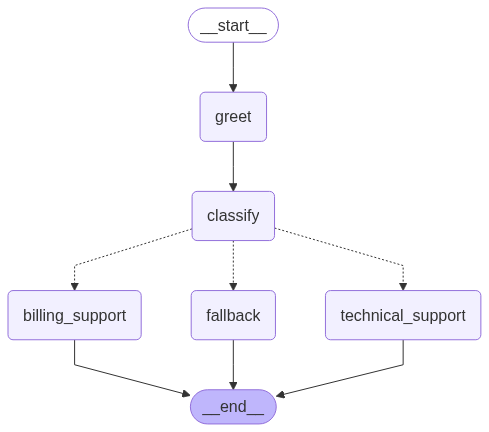

In [49]:
from IPython.display import Image,display
display(Image(runnable_graph.get_graph().draw_mermaid_png()))